# **Recurrent Neural Networks and Text Classification**


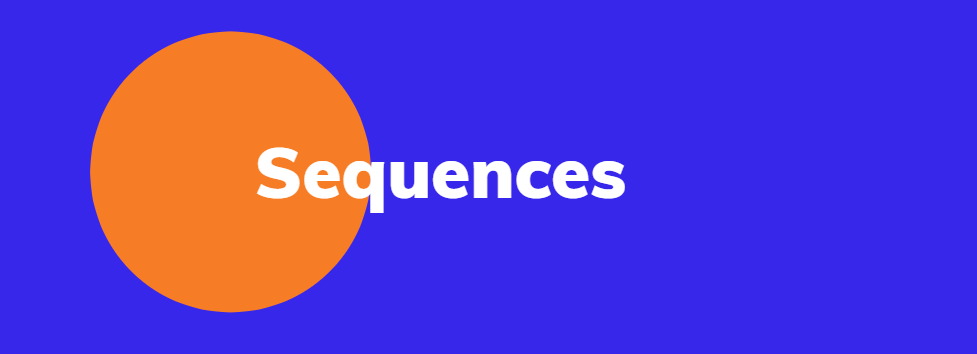

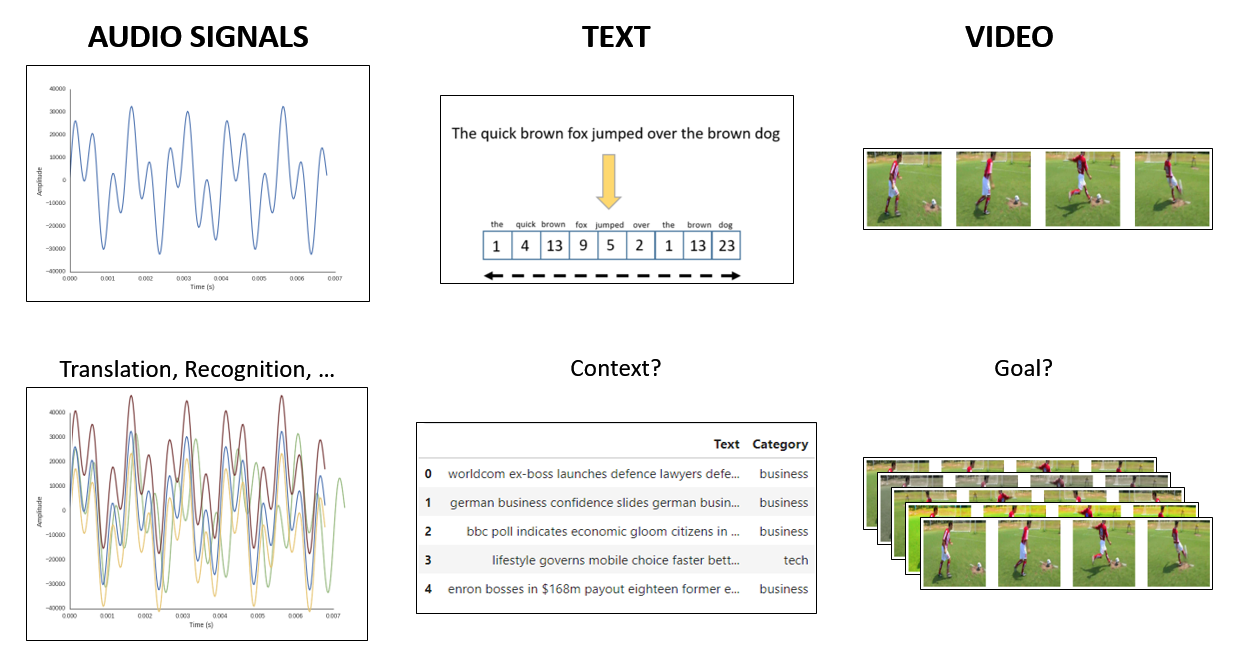

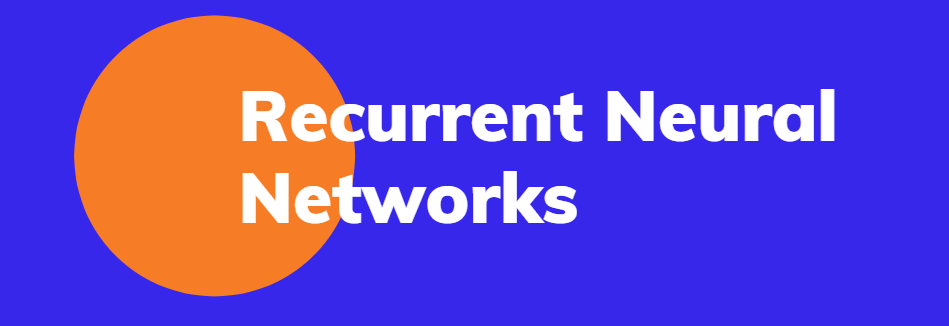

- Recurrent neural network is a type of network architecture that accepts variable inputs and variable outputs
- The each neuron **takes in input** the **output of the previous neuron**
- The state at a certain step of the sequence is propagated

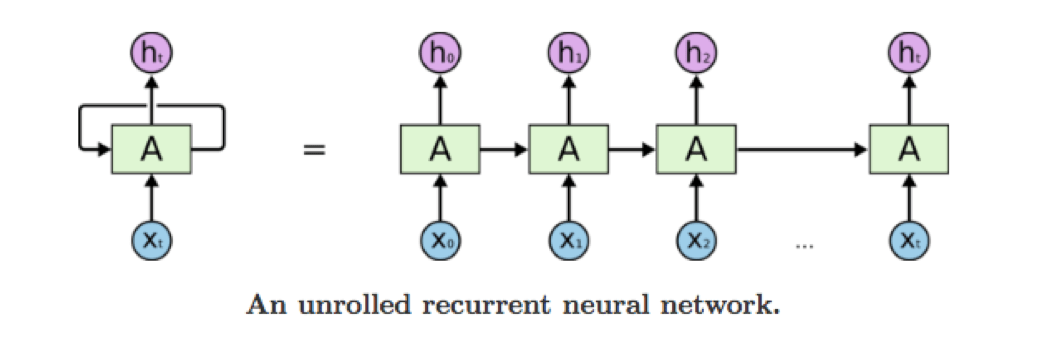



---
### **Different typse of RNN architectures**  



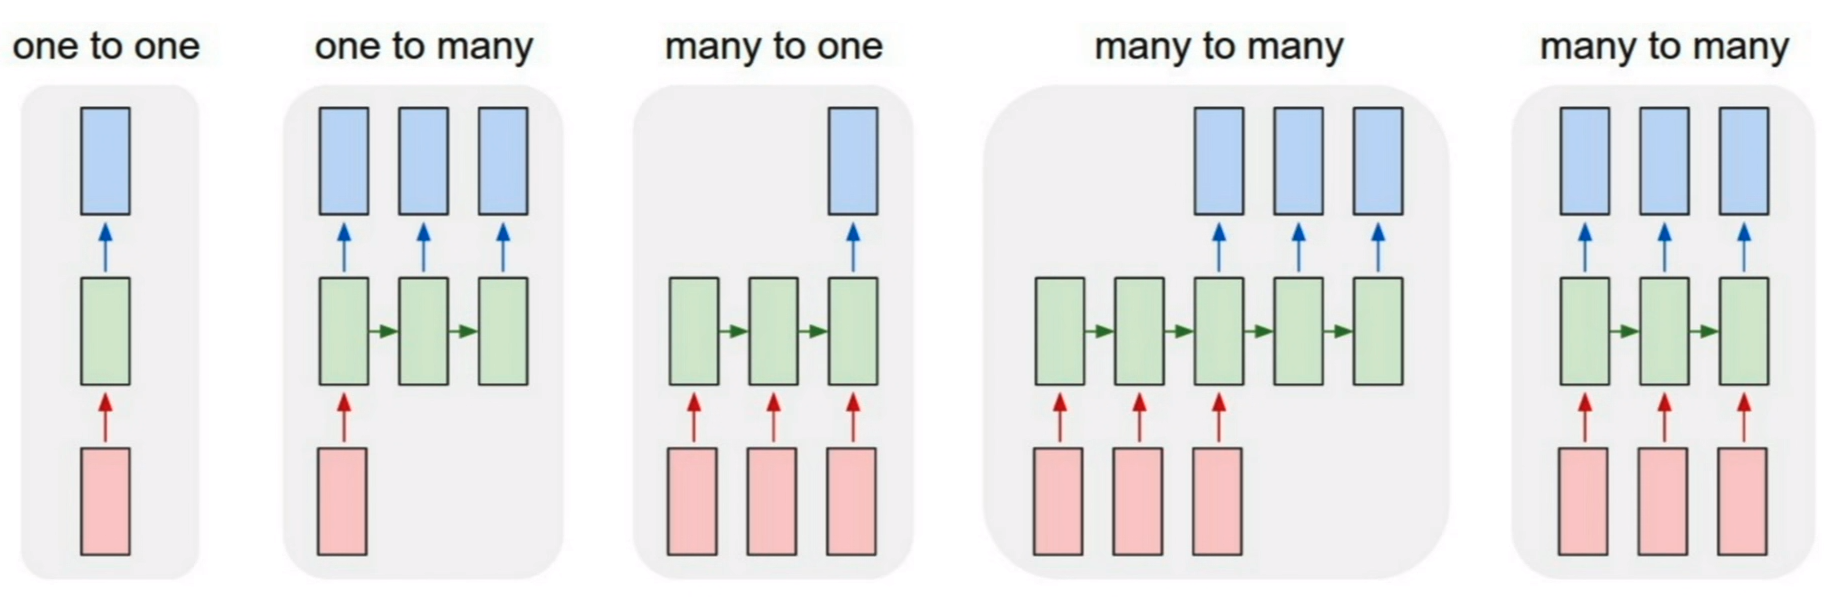

> - **One-to-one** - classic feed forward neural network architecture, with one input and we expect one output.
- **One-to-many** - e.g. image captioning. We have one image as a fixed size input and the output can be words or sentences which are variable in length.
- **Many-to-one** e.g. sentiment classification. The input is expected to be a sequence of words or even paragraphs of words. The output can be a regression output with continuous values which represent the likelihood of having a positive sentiment.
- **Many-to-many** - machine translation like in  Google translate. The input
could an English sentence which has variable length and the output will be the same sentence in a different language which also has variable length. The last many to many model can be used for video classification on frame level. Feed every frame of a video into the neural network and expect an output right away. However, since frames are generally dependent on each other, it is necessary for the network to propagate its hidden state from the previous to the next. Thus, we need recurrent neural network for this kind of task.

### **Different Types of Blocks**

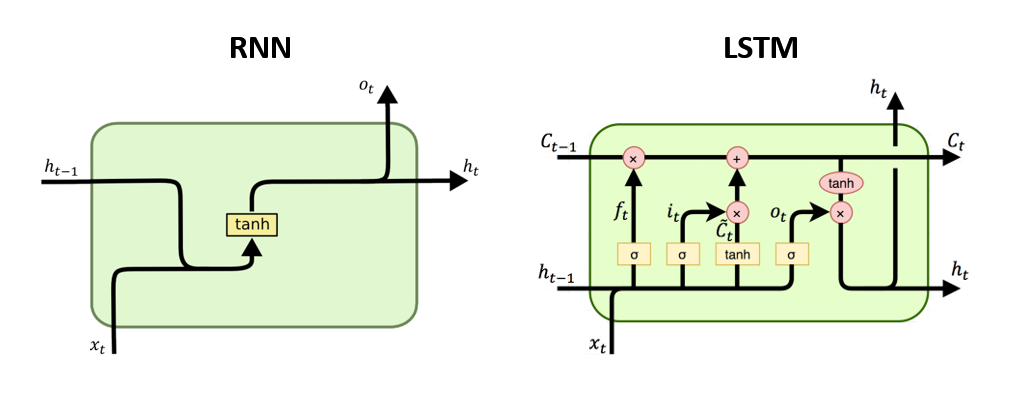

### **LSTM**
#### Long Short Term Memory


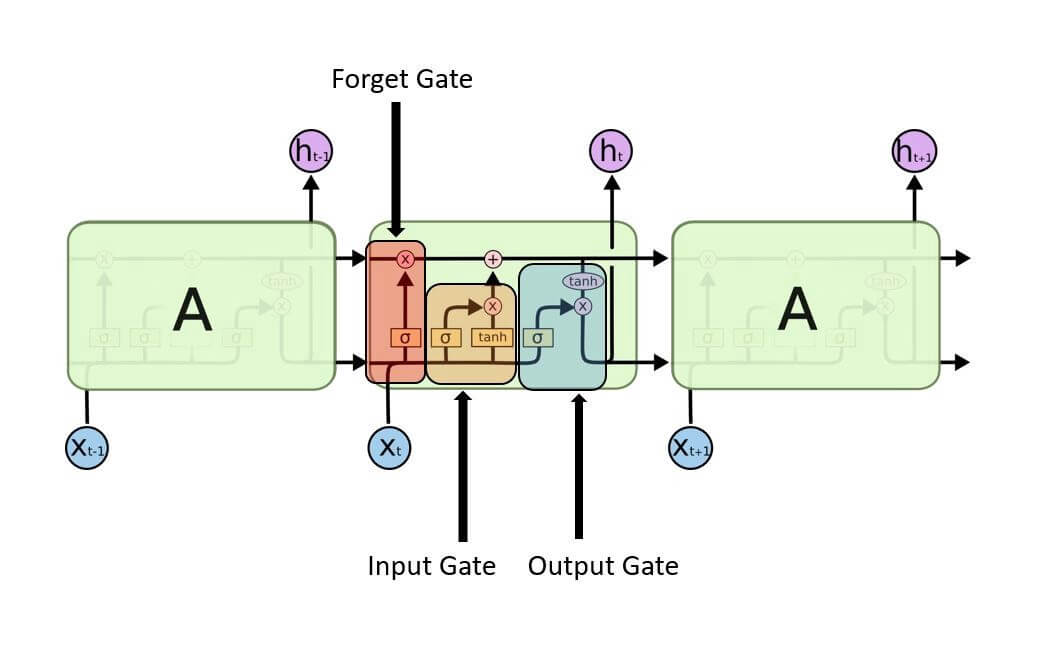

> - **Forget Gate** - decides which information from long term memory be kept or discarded and this is done by multiplying the incoming long term memory (upper incoming arrow) by a forget vector generated by the current input and incoming short memory (lower arrow).

> - **Input Gate** - decides what information will be stored in long term memory. It only works with the information from the current input and short term memory from the previous step. At this gate, it filters out the information from variables that are not useful.


> - **Output Gate** - it takes the current input, the previous short term memory and newly computed long term memory to produce new short term memory which will be passed on to the cell in the next time step. The output of the current time step can also be drawn from this hidden state.

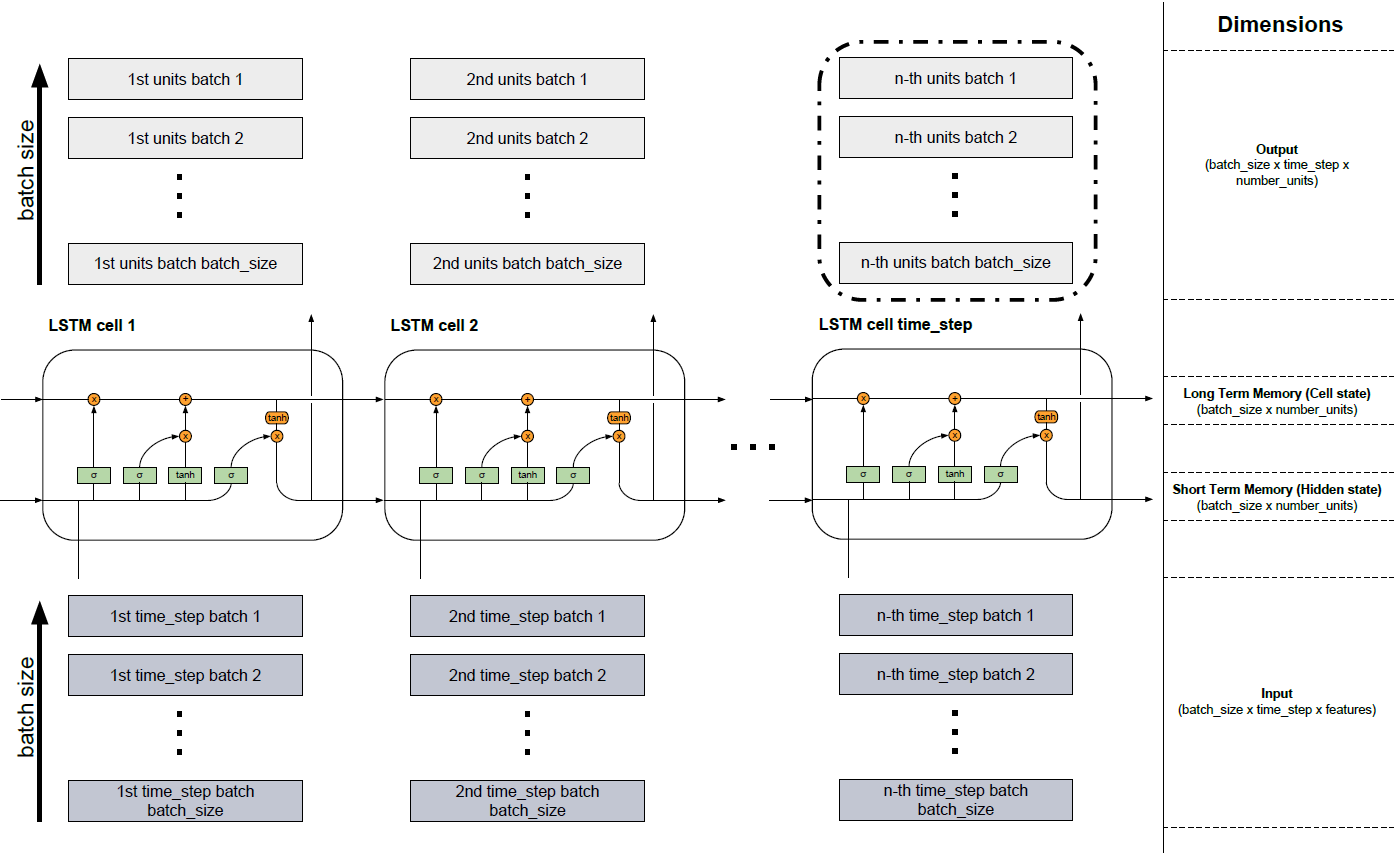

### **Natural Language Processing**
####An Example of Text Classification



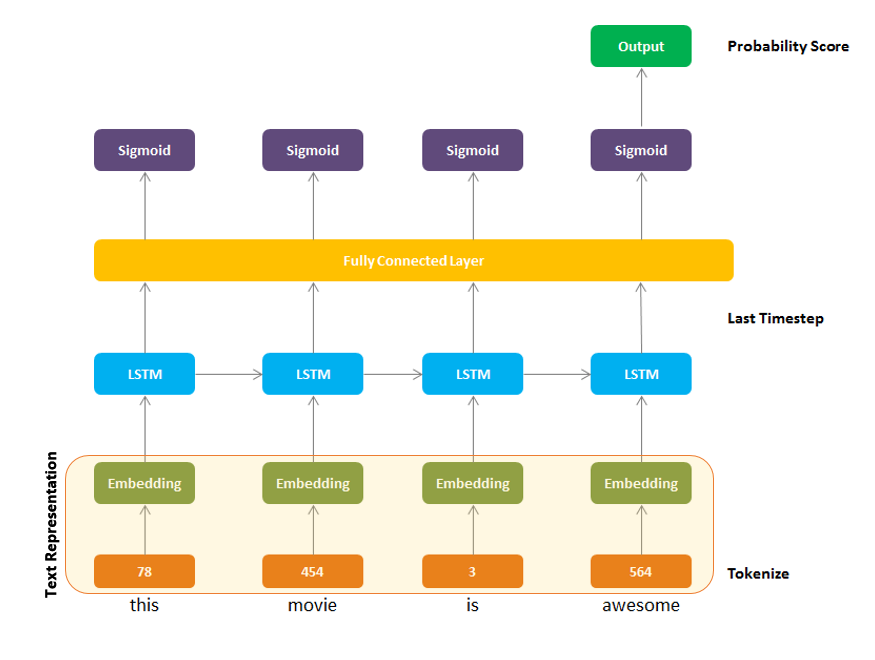

## **Representing Text**

Machine learning models take vectors (arrays of numbers) as input. When working with text, the first thing you must do is come up with a strategy to convert strings to numbers (or to "vectorize" the text) before feeding it to the model. In this section, you will look at three strategies for doing so.



---



### One-hot encodings

As a first idea, you might "one-hot" encode each word in your vocabulary. Consider the sentence "The cat sat on the mat". The vocabulary (or unique words) in this sentence is (cat, mat, on, sat, the). To represent each word, you will create a zero vector with length equal to the vocabulary, then place a one in the index that corresponds to the word. This approach is shown in the following diagram.

<img src="https://github.com/tensorflow/text/blob/master/docs/guide/images/one-hot.png?raw=1" alt="Diagram of one-hot encodings" width="400" />

To create a vector that contains the encoding of the sentence, you could then concatenate the one-hot vectors for each word.

Key point: This approach is inefficient. A one-hot encoded vector is sparse (meaning, most indices are zero). Imagine you have 10,000 words in the vocabulary. To one-hot encode each word, you would create a vector where 99.99% of the elements are zero.



---



### Encode each word with a unique number

A second approach you might try is to encode each word using a unique number. Continuing the example above, you could assign 1 to "cat", 2 to "mat", and so on. You could then encode the sentence "The cat sat on the mat" as a dense vector like [5, 1, 4, 3, 5, 2]. This approach is efficient. Instead of a sparse vector, you now have a dense one (where all elements are full).

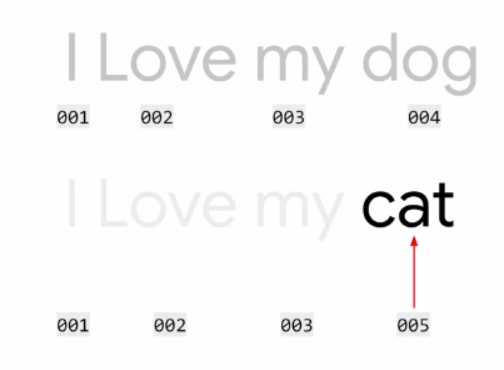

There are two downsides to this approach, however:

* The integer-encoding is arbitrary (it does not capture any relationship between words).

* An integer-encoding can be challenging for a model to interpret. A linear classifier, for example, learns a single weight for each feature. Because there is no relationship between the similarity of any two words and the similarity of their encodings, this feature-weight combination is not meaningful.



---



### Word embeddings

Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

<img src="https://github.com/tensorflow/text/blob/master/docs/guide/images/embedding2.png?raw=1" alt="Diagram of an embedding" width="400"/>

Above is a diagram for a word embedding. Each word is represented as a 4-dimensional vector of floating point values. Another way to think of an embedding is as "lookup table". After these weights have been learned, you can encode each word by looking up the dense vector it corresponds to in the table.



---



Vsualize them in the [Embedding Projector](http://projector.tensorflow.org) (shown in the image below).

<img src="https://github.com/tensorflow/text/blob/master/docs/guide/images/embedding.jpg?raw=1" alt="Screenshot of the embedding projector" width="400"/>



---



# **IMDb Dataset Example**

## Setup

In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

ModuleNotFoundError: No module named 'tensorflow_datasets'

Import `matplotlib` and create a helper function to plot graphs:

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets).

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

print(train_dataset.element_spec)
print(train_dataset.cardinality().numpy())

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteJSQ56K/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteJSQ56K/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteJSQ56K/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
25000


Initially this returns a dataset of (text, label pairs):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.


`.prefetch()` overlaps data preprocessing and model execution while training.


In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"This is supposed to be well-researched and based on fact. How come therefore that it's so packed with McGovernisms. Did the people of Derry live in some kind of bizarre Philip K. Dick world in which reality was uncannily like Cracker/ Liam/ Priest? Or is McGovern an idle hack who just keeps repeating hims"
 b'Dreadful acting. A thinly veiled attempt to slam those on the left side of the aisle.<br /><br />Women are subjugated and revolve around men. Tom Selleck shows his acting range from A to B.'
 b"I remember watching this film back in 86' when it first came out & what an awful film. The acting was atrocious the plot was so flimsy it would or is that should have blew away in a breath of wind. I think it put me to sleep on more than one occasion & i was not tired that i remember. Please avoid at all costs better still have all your teeth taken out with no anaesthetic cos that would be more entertaining. It's just a pity i couldn't give it a zero or a negative score. I wish i

## Create the text encoder

- The raw text loaded by `tfds` needs to be processed before it can be used in a model.
- The simplest way to process text for training is using the `TextVectorization` layer.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

- The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens.
- When the number of unique words is greater than `VOCAB_SIZE`, it selects the words with the highest number of occurrences over the entire dataset.
- After the padding and unknown tokens they're sorted by frequency:

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

- Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are **0-padded** to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11,   7, 402, ...,   0,   0,   0],
       [  1, 112,   4, ...,   0,   0,   0],
       [ 10, 364, 147, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size results in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"This is supposed to be well-researched and based on fact. How come therefore that it's so packed with McGovernisms. Did the people of Derry live in some kind of bizarre Philip K. Dick world in which reality was uncannily like Cracker/ Liam/ Priest? Or is McGovern an idle hack who just keeps repeating hims"
Round-trip:  this is supposed to be [UNK] and based on fact how come [UNK] that its so [UNK] with [UNK] did the people of [UNK] live in some kind of [UNK] [UNK] [UNK] [UNK] world in which reality was [UNK] like [UNK] [UNK] [UNK] or is [UNK] an [UNK] [UNK] who just keeps [UNK] [UNK]                                                                                                                                                                                                                                                                                                                                                                                                             

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model.

>**1**. This model can be build as a `tf.keras.Sequential`.

>**2**. The first layer is the `encoder`, which converts the text to a sequence of token indices.

>**3**. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. **These vectors are trainable**. After training (on enough data), words with similar meanings often have similar vectors.

>**4**. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep. \\

- The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main **advantage** of a **bidirectional RNN** is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main **disadvantage** of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

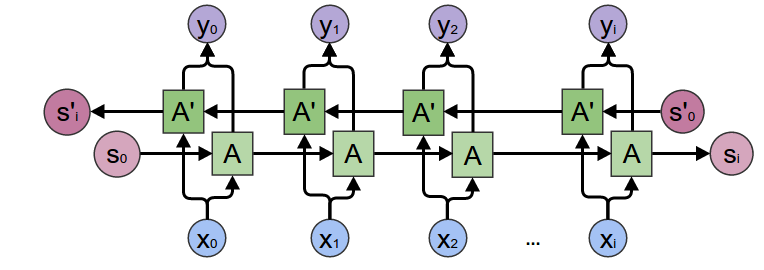

>**5**. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.


## Using the Embedding layer

Keras makes it easy to use word embeddings.  
Take a look at the [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

> - The Embedding layer can be understood as a **TRAINABLE** lookup table that **maps** from **integer** indices (which stand for specific words) **to dense vectors** (their embeddings).
- The dimensionality (or **width**) **of the embedding** is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer.
- This layer can only be used on positive integer inputs.


In [ ]:
# Embed a 1,000 word vocabulary into 5 dimensions.
embedding_layer = tf.keras.layers.Embedding(1000, 5)

- When you create an Embedding layer, the weights for the embedding are randomly initialized (just like any other layer).
- During training, they are gradually adjusted via backpropagation.
- Once trained, the learned word embeddings will roughly encode similarities between words (as they were learned for the specific problem your model is trained on).

If you pass an integer to an embedding layer, the result replaces each integer with the vector from the embedding table:

In [ ]:
result = embedding_layer(tf.constant([1, 2, 3]))
result.numpy()

array([[ 0.00057508, -0.00181558, -0.04800426,  0.00970761, -0.0147991 ],
       [ 0.01767682,  0.04545171, -0.01243435, -0.00475228, -0.03668463],
       [-0.04635768,  0.04810778,  0.00655669,  0.00283523,  0.0241202 ]],
      dtype=float32)

For text or sequence problems, the Embedding layer takes a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of integers. It can embed sequences of variable lengths. You could feed into the embedding layer above batches with shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15).

The returned tensor has one more axis than the input, the embedding vectors are aligned along the new last axis. Pass it a `(2, 3)` input batch and the output is `(2, 3, N)`


In [ ]:
result = embedding_layer(tf.constant([[0, 1, 2], [3, 4, 5]]))
result.shape

TensorShape([2, 3, 5])

When given a batch of sequences as input, an embedding layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. To convert from this sequence of variable length to a fixed representation there are a variety of standard approaches. You could use an RNN, Attention, or pooling layer before passing it to a Dense layer. This tutorial uses pooling because it's the simplest.

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

The code to implement this is below:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=3,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Compile the Keras model to configure the training process:

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4), # default 0.01
              metrics=['accuracy'])

## Train the model

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 48s 91ms/step - loss: 0.6889 - accuracy: 0.5027 - val_loss: 0.6527 - val_accuracy: 0.5151
Epoch 2/10
391/391 [==============================] - 33s 83ms/step - loss: 0.5951 - accuracy: 0.6517 - val_loss: 0.5280 - val_accuracy: 0.6932
Epoch 3/10
391/391 [==============================] - 33s 83ms/step - loss: 0.4692 - accuracy: 0.7705 - val_loss: 0.4139 - val_accuracy: 0.7948
Epoch 4/10
391/391 [==============================] - 33s 82ms/step - loss: 0.4010 - accuracy: 0.8182 - val_loss: 0.3779 - val_accuracy: 0.8208
Epoch 5/10
391/391 [==============================] - 33s 83ms/step - loss: 0.3733 - accuracy: 0.8321 - val_loss: 0.3662 - val_accuracy: 0.8224
Epoch 6/10
391/391 [==============================] - 33s 84ms/step - loss: 0.3607 - accuracy: 0.8419 - val_loss: 0.3547 - val_accuracy: 0.8380
Epoch 7/10
391/391 [==============================] - 33s 84ms/step - loss: 0.3429 - accuracy: 0.8505 - val_loss: 0.3447 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 20s 51ms/step - loss: 0.3336 - accuracy: 0.8609
Test Loss: 0.33356326818466187
Test Accuracy: 0.8609200119972229


(0.0, 0.7069844543933869)

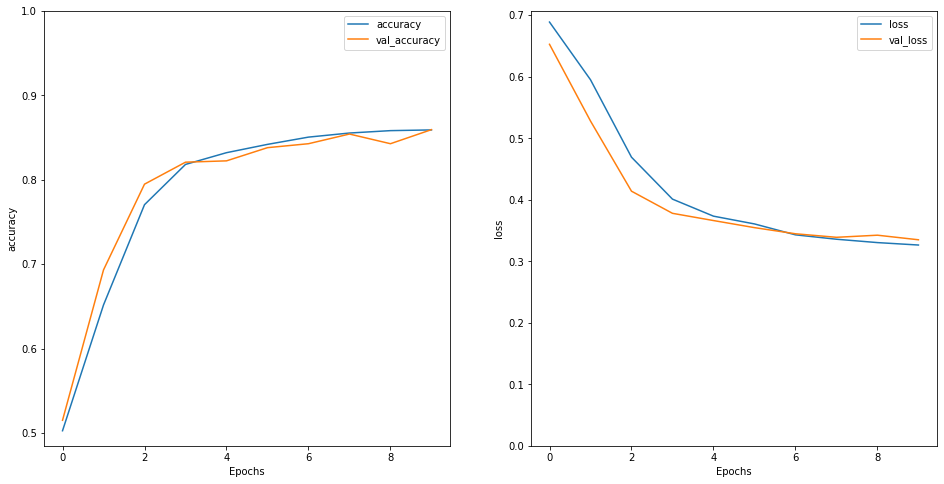

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[0.9375597]]


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).



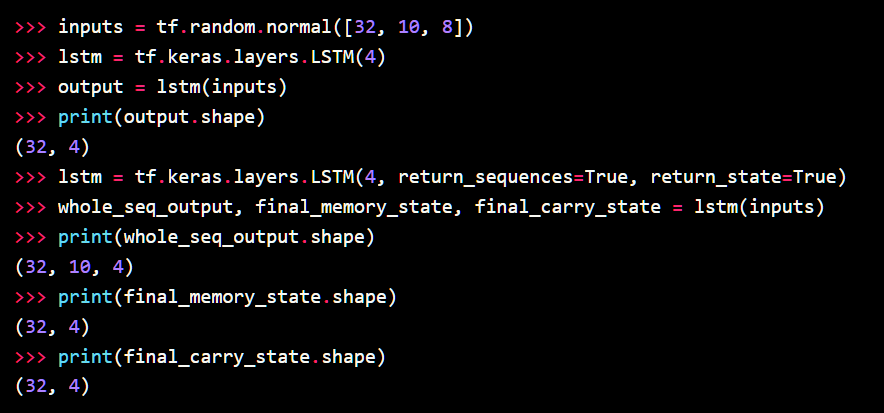



---


Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

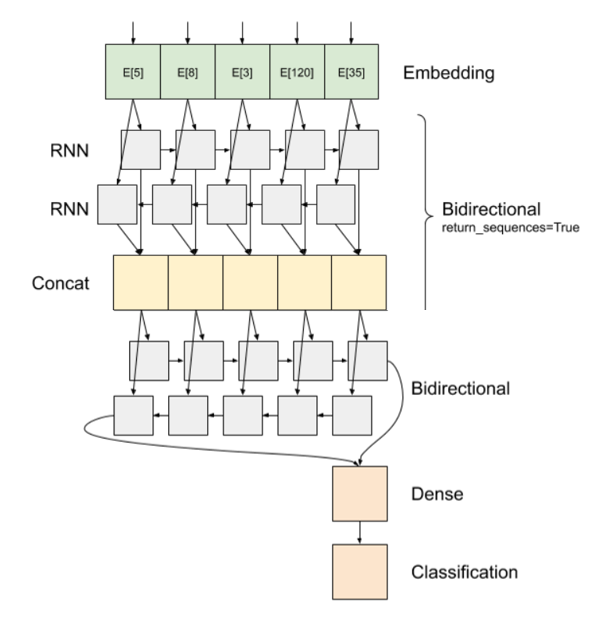

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 72s 150ms/step - loss: 0.5945 - accuracy: 0.6164 - val_loss: 0.3939 - val_accuracy: 0.8281
Epoch 2/10
391/391 [==============================] - 55s 139ms/step - loss: 0.3759 - accuracy: 0.8375 - val_loss: 0.3585 - val_accuracy: 0.8552
Epoch 3/10
391/391 [==============================] - 55s 139ms/step - loss: 0.3318 - accuracy: 0.8602 - val_loss: 0.3262 - val_accuracy: 0.8583
Epoch 4/10
391/391 [==============================] - 59s 150ms/step - loss: 0.3178 - accuracy: 0.8627 - val_loss: 0.3236 - val_accuracy: 0.8531
Epoch 5/10
391/391 [==============================] - 55s 140ms/step - loss: 0.3136 - accuracy: 0.8661 - val_loss: 0.3598 - val_accuracy: 0.8167
Epoch 6/10
391/391 [==============================] - 56s 141ms/step - loss: 0.3067 - accuracy: 0.8710 - val_loss: 0.3356 - val_accuracy: 0.8568
Epoch 7/10
391/391 [==============================] - 55s 139ms/step - loss: 0.3035 - accuracy: 0.8680 - val_loss: 0.3187 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 29s 74ms/step - loss: 0.3159 - accuracy: 0.8614
Test Loss: 0.3159066140651703
Test Accuracy: 0.8614000082015991


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-2.0966885]]


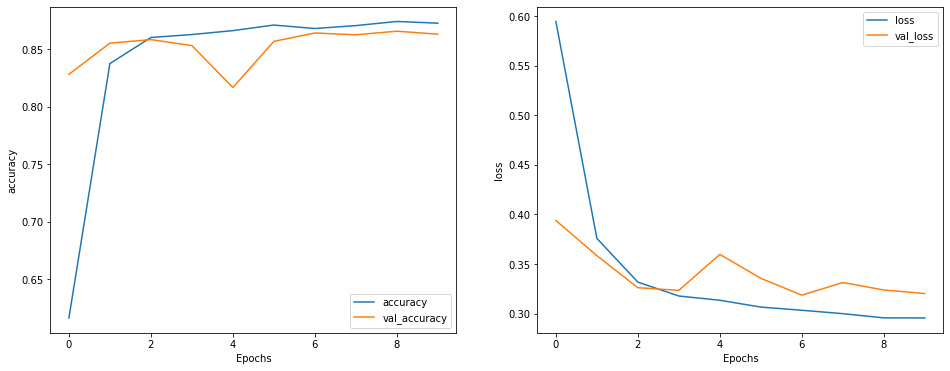

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')